# Gyanús hirdetések nyomában

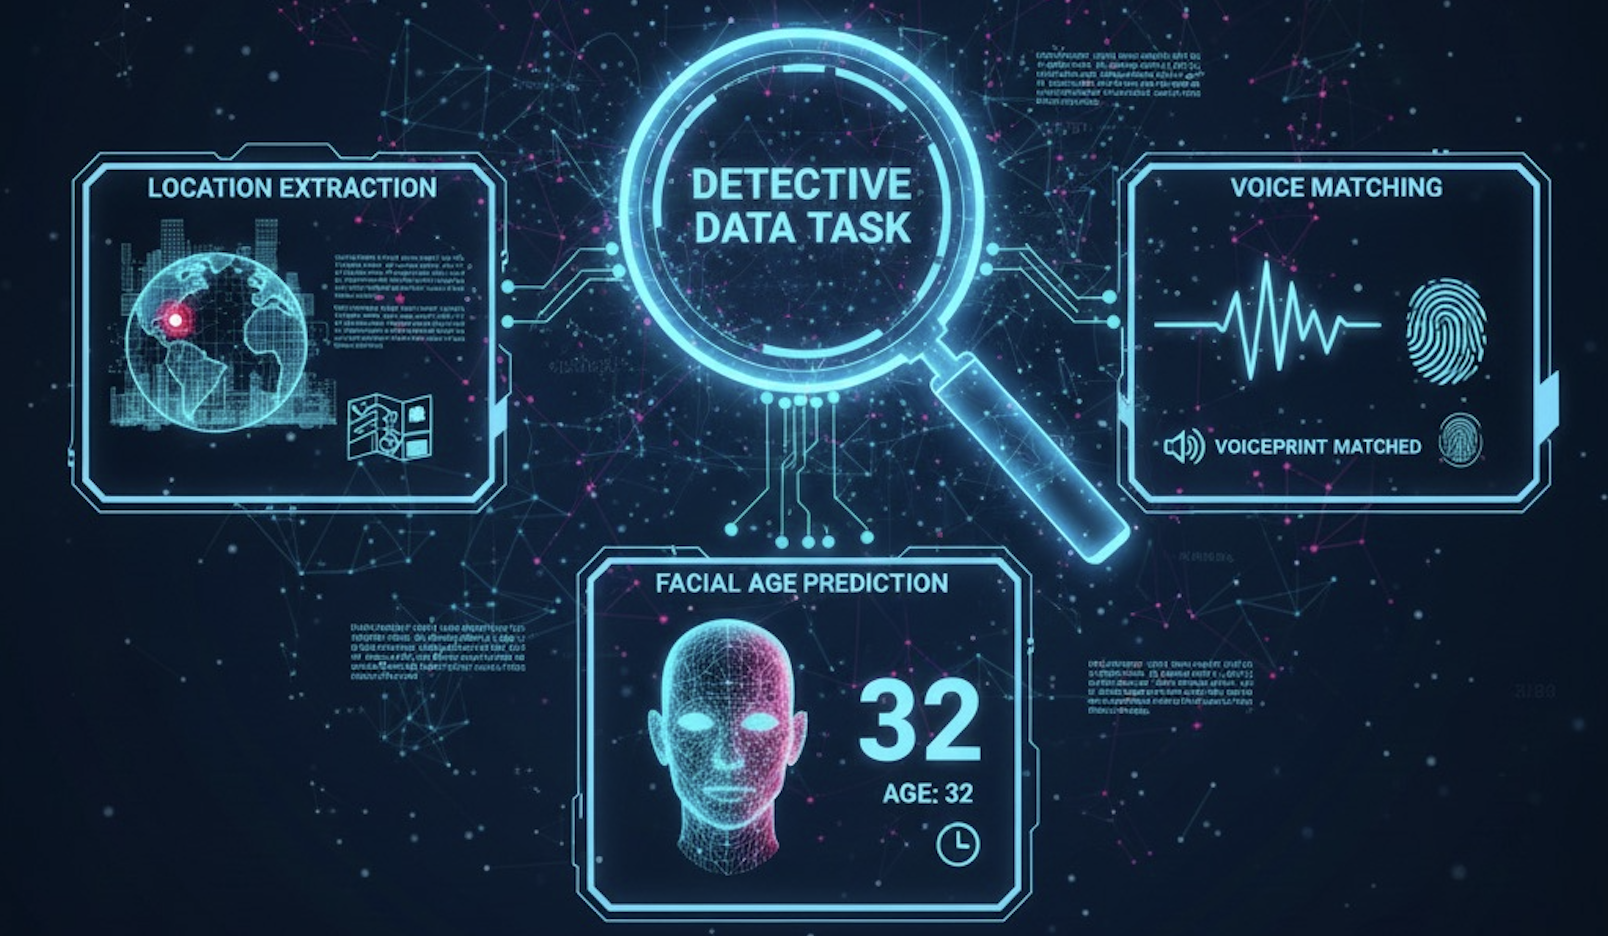

**Ez a feladat 3 kérdésből áll, de a keretsztori és a Colab notebook ugyanaz!**

**FONTOS: az első három cellát még most futtasd le, utána olvass tovább!!!**

A rendőrségnél data science gyakornokként a feladatod, hogy technológiai megoldásokkal támogasd a nyomozásokat. Már annyira a mindennapjaid részévé vált ez a szemlélet, hogy gyakran azon kapod magad: ha hozzáférhetnél minden adatrögzítő eszközhöz, mennyi információmorzsát tudnál összerakni, bűncselekményt megoldani… Ebben a feladatban pont egy ilyen nyomozás részese lehetsz!

Már régóta vágysz egy új biciklire a munkába járáshoz, ezért minden reggel átböngészed a környékbeli marketplace-hirdetéseket. Sok gyanús alakot láttál már drága bicikliket árulni, gyakran teszed fel magadban a kérdést, hogy 'Hozzá vajon hogyan került?!'. Mivel jól ismered az árakat, mindig gyanút fogsz, ha egy bringát a piaci ár töredékéért, „nagyon sürgősen” kínálnak eladásra — főleg, ha az eladó bár azt állítja, hogy a saját kedvencét árulja, mégis alig tud róla bármit, és szűkszavúan mentegetőzik a kérdésekre.

Egyik reggel ismét megakad a szemed pár menő biciklin, amiket piaci ár alatt kínálnak, ha még aznap átveszed. Hirtelen eszedbe jut, hogy nemrég fejeztél be egy projektet, ami a rendőrségi RSS-híreket menti le naponta. Ha sikerülne az adatokat az elkövetés helye és a bűncselekmény típusa szerint címkézni, talán kideríthetnéd, hogy történt-e mostanában biciklilopás Egerben - ami még gyanúsabbá tenné a hirdetéseket...

GPU: nem kell ehhez a feladathoz, de gyorsít a predikción


In [ ]:
%%capture
!pip install huspacy
!pip install speechbrain
!pip install -U "packaging<24"

In [ ]:
%%capture
!pip install torch==2.8.0 torchvision==0.23.0 torchaudio==2.8.0 --index-url https://download.pytorch.org/whl/cu129

In [ ]:
# Ha bármiért elakadna a letöltés, használd a feladathoz csatolt fájlokat!
%%capture
!gdown 1gIMJEbdsziSmKjFn0768qaXEiEl-pyVc # age prediction weights
!gdown 1kQqt_1ZItVT4dpLHz8_l8THwAdiacJAu # rendőrségi hírek
!gdown 10A6Et9gxutHk8nY3tbr3wH415SA42Pp9 # hanganyag
!gdown 1pq0ciPaaM7XpHe7_JM-0nZuzByoJE13t # arcképek

!unzip -o -q hanganyag.zip
!unzip -o -q security_cam_face_crops.zip

##Rendőrségi hírek tagelése és elemzése

In [ ]:
import xml.etree.ElementTree as ET
import pandas as pd
import re
from transformers import pipeline
import huspacy
import spacy
import tqdm
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderServiceError

huspacy.download("hu_core_news_lg")
nlp = spacy.load("hu_core_news_lg")

In [ ]:
def strip_hungarian_suffix(word: str):
    suffixes = [
        "ban", "ben", "ba", "be", "ra", "re", "n", "on", "en", "ön",
        "ról", "ről", "tól", "től", "hoz", "hez", "höz"
    ]

    # TODO: Tisztítsd meg a helyszínekre utaló szavakat a toldalékoktól, a városok azonosításához
    for suffix in sorted(suffixes, key=len, reverse=True):
        if word.endswith(suffix):
            return word[:-len(suffix)]
    return word



def extract_and_normalize_location(sentence: str):
    if not sentence:
        return None
    doc = nlp(sentence)
    for ent in doc.ents:
      # TODO: a betöltött nlp modell segítségével válaszd ki a helyszínre utaló szavakat ("LOC", "GPE") - https://spacy.io/usage/linguistic-features
        if ent.label_ in ["LOC", "GPE"]:
            return strip_hungarian_suffix(ent.text)
    return None



def resolve_with_osm(place_name: str, country: str = "Hungary"):
    geolocator = Nominatim(user_agent="geo_norm_script")
    query = f"{place_name}, {country}"
    try:
        result = geolocator.geocode(query, language="hu")
    except GeocoderServiceError:
        return None
    if result:
        return {
            "osm_name": result.raw.get("display_name"),
            "latitude": result.latitude,
            "longitude": result.longitude
        }
    return None

In [ ]:
# Bűnügyi hírek betöltése
tree = ET.parse("bun.xml")
root = tree.getroot()

items_data = []
for item in root.findall(".//item"):
    data = {}
    for child in item:
        data[child.tag] = child.text.strip() if child.text else ""
    items_data.append(data)

In [ ]:
# TODO: futtasd le a cikkek elemzéséhez szükséges függvényeket, hogy megkapd az események helyszíneit

for item in tqdm.tqdm(items_data, desc = "Extracting places in progress..."):
    desc = item.get("description", "")
    base_name = extract_and_normalize_location(desc)
    if base_name:
        osm_data = resolve_with_osm(base_name)
        if osm_data:
            item.update(osm_data)
        else:
            item["osm_name"] = base_name
            item["latitude"] = None
            item["longitude"] = None
    else:
        item["osm_name"] = None
        item["latitude"] = None
        item["longitude"] = None

In [ ]:
# TODO: Használd a https://huggingface.co/joeddav/xlm-roberta-large-xnli linken található modellt a hírek kategorizálásához

classifier = pipeline("zero-shot-classification", model="joeddav/xlm-roberta-large-xnli")

candidate_labels = [
    "kerékpárlopás",
    "betörés",
    "autólopás",
    "rablás",
    "zsebtolvajlás",
    "erőszakos bűncselekmény",
    "gyújtogatás"
]

for item in tqdm.tqdm(items_data, desc = "Classication in progress..."):
    description = item.get("description", "")
    if description:
        pred = classifier(description, candidate_labels)
        item["predicted_label"] = pred['labels'][0]
        item["score"] = pred['scores'][0]
    else:
        item["predicted_label"] = None
        item["score"] = None

In [ ]:
df = pd.DataFrame(items_data)
condition = (df["osm_name"].str.contains("Eger", case=False, na=False)) & (df["predicted_label"] == "kerékpárlopás")
filtered = df[condition]
pd.set_option('display.max_colwidth', None)

In [ ]:
filtered

Találsz is egy elég gyanús bejegyzést, amihez személyleírás is tartozik - talán ez elég bizonyíték lehet ahhoz, hogy a technológiával szemben amúgy szkeptikus felettesedet meggyőzd: érdemes lenne utánanézni az ügynek.

Be is avatnak a részletekbe, és kiderül, hogy a lopott bicikli leírása kísértetiesen hasonlít több hirdetésben szereplő kerékpárra is. Két adatforrás is rendelkezésre áll, de egyik sem köti egyértelműen elkövetőhöz az esetet:
- Az egyik egy közeli szolárium biztonsági kamerája, ami felvette az utcán elsétáló embereket.
- A másik egy parkoló autó menetrögzítője, ami bár rossz szögből rögzített, de a mozgásérzékelés miatt hangfelvétel is készült — hallatszik rajta, ahogy valaki a zárral bíbelődik.

Ezekkel az adatokkal vágsz neki a nyomozásnak...


## **Válaszolj a 1/3 kérdésre a Megmérettetés felületén!**

1.Kérdés: Mi a rendőrségi hír dátuma?

pl.: Június 26. esetén -> '0626' formátumban várjuk

##Biztonsági kamera felvételek elemzése
Az egyik kollégád már eljutott odáig, hogy a feltételezett idősávban készült felvételt feldolgozta és kivágta a járókelők arcát, hogy könnyebben azonosíthatóak legyenek. Egy probléma van, ez egy igen forgalmas utca, így rengeteg arcképen kellene átrágnia magát annak, aki a személyleírás alapján keres valakit...

Szerencse, hogy volt egy egyetemi projekted, ahol pont emberek korának becslése volt a téma arcképek alapján, így rendelkezésedre áll a betanított modell, már csak le kell futtatni az arcképekre és összevetni a személyleírással, hogy szűkítsd a gyanúsítottak körét!

In [ ]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from glob import glob

class AgeCNN(nn.Module):
    def __init__(self):
        super(AgeCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x.squeeze(1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AgeCNN().to(device)
model.load_state_dict(torch.load("/content/age_pred.pth", map_location=device))
model.eval()

input_folder = "/content/security_cam_face_crops"

'''
  TODO: Futtasd le a korbecslő modellt a kamerafelvételekről kivágott arcképekre és keresd meg a személyleírással egyező gyanúsítottat!
  image preprocessing hint:

  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (64, 64))
  img = img / 255.0
  img = np.transpose(img, (2, 0, 1))
  img = torch.tensor(img, dtype=torch.float32).unsqueeze(0).to(device)
'''

results = []
image_paths = glob(os.path.join(input_folder, "*.jpg")) + glob(os.path.join(input_folder, "*.png"))

for path in image_paths:
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (64, 64))
    img = img / 255.0
    img = np.transpose(img, (2, 0, 1))
    img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).to(device)
    
    with torch.no_grad():
        predicted_age = model(img_tensor).item()
    
    results.append({
        "filename": os.path.basename(path),
        "predicted_age": predicted_age
    })

df = pd.DataFrame(results)
# A személyleírás alapján szűrés (a konkrét kor a hírből derül ki - általában 25-35 év közötti férfi)
# Szűrjük a becsült kor alapján
condition = (df["predicted_age"] >= 25) & (df["predicted_age"] <= 35)
filtered = df[condition]
print(filtered)

## **Válaszolj a 2/3 kérdésre a Megmérettetés felületén!**

2.Kérdés: Mi az azonosított kép fájlneve?

kiterjesztés nélkül: pl.: 202510081325.jpg -> '202510081325' formátumban várjuk

##Terepmunka és hangelemzés

A hagyományos nyomozás eredményére nem várhatsz - addigra biztos eladják a biciklit, és kihűl a nyom. Ekkor eszedbe jut a hangminta...
Úgy döntesz, megpróbálod összevetni a hirdetők hangját a helyszíni felvétellel. Ehhez fel kell hívnod a hirdetőket, hogy megszerezd a hangmintákat. Ha egyezést találsz, az már elég bizonyíték lehet a főnöködnek, hogy mozgósítsa a rendőrségi erőforrásokat és fény derüljön a lopásra!

Minden hívásból sikerült rögzítetted az eladó hangmintáját, így nincs más dolgod, mint összevetni a tolvajéval.


In [ ]:
import os
import torchaudio
import torch
import numpy as np
from itertools import combinations
from speechbrain.pretrained import SpeakerRecognition


model = SpeakerRecognition.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb", savedir="tmp/spkrec")

def preprocess_audio(path):
    waveform, sr = torchaudio.load(path)
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)
    if sr != 16000:
        resampler = torchaudio.transforms.Resample(sr, 16000)
        waveform = resampler(waveform)
    return waveform

def get_embedding(waveform):
    with torch.no_grad():
        emb = model.encode_batch(waveform).squeeze(0).squeeze(0).cpu().numpy()
    return emb

def cosine_distance(a, b):
    # TODO: implementáld a cosine distance függvényt, hogy összehasonlíthasd a hangfelvételeket
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    cosine_similarity = dot_product / (norm_a * norm_b)
    return 1 - cosine_similarity  # cosine distance = 1 - cosine similarity

security_footage_audio = 'helyszini_felvetel_1023432.mp3'
recorded_calls = [
    "elado_attila_3523432.mp3",
    "elado_gabor_4565432.mp3",
    "elado_jakub_5739193.mp3",
    "elado_olga_9864828.mp3",
    "elado_oszkar_3764821.mp3",
    "elado_tibor_2419768.mp3"
]

# TODO: Használd a betöltött modellt, hogy legeneráld a hangfelvételek embeddingjeit és hasonlítsd össze a helyszínen rögzített hangmintával.
# Tipp: Ne felejts el használni a preprocess_audio függvényt az embeddingek generálása előtt!

# Helyszíni felvétel embeddingjének generálása
security_waveform = preprocess_audio(security_footage_audio)
security_embedding = get_embedding(security_waveform)

# Összes hívás összehasonlítása a helyszíni felvétellel
results = []
for call in recorded_calls:
    call_waveform = preprocess_audio(call)
    call_embedding = get_embedding(call_waveform)
    distance = cosine_distance(security_embedding, call_embedding)
    results.append({
        "filename": call,
        "cosine_distance": distance
    })

# Eredmények kiírása és a legközelebbi egyezés megtalálása
results_df = pd.DataFrame(results)
results_df = results_df.sort_values("cosine_distance")
print(results_df)

# A legkisebb távolságú (leginkább egyező) hang
best_match = results_df.iloc[0]
print(f"\nLegjobb egyezés: {best_match['filename']} (cosine distance: {best_match['cosine_distance']:.4f})")

# Telefonszám kinyerése a fájlnévből
phone_number = best_match['filename'].split('_')[-1].replace('.mp3', '')
print(f"Telefonszám: {phone_number}")

##Megoldás

Ha idáig jutottál gratulálunk, már csak át kell adnod az általad gyűjtött adatokat az elkövetőről:

- a rendőrségi hír dátuma: pl.: Június 26. -> '0626'
- az azonosított kép fájlneve, kiterjesztés nélkül: pl.: 202510081325.jpg -> '202510081325'
- az azonosított hirdető telefonszáma, amit szintén a fájlnév tartalmaz: pl.: elado_gabor_4565432.mp3 -> '4565432'


## **Válaszolj a 3/3 kérdésre a Megmérettetés felületén!**

3.Kérdés: Mi az azonosított hirdető telefonszáma, amit szintén a fájlnév tartalmaz?

pl.: elado_gabor_4565432.mp3 -> '4565432' formátumban várjuk